# Manipulating Layers of ARIA standard GUNW products

**Author**: Brett A. Buzzanga, David Bekaert - Jet Propulsion Laboratory

This notebook documents the methodology used for extracting data and metadata layers of ARIA Geocoded UNWrapped interferogram (**GUNW**) products. It provides command-line and python examples that include visualizations and an application. 

Specifically, we detail the methodology used in extracting:
- product bounding box, amplitude, and coherence,
- imaging geometry, 
- unwrapped phase. 

We then show examples which use the tools to extract based on:
- the full union of the acquisition frames (no bounding box),
- a bounding box of SNWE coordinates in decimal degrees,
- a bounding box in the form of a vector shapefile.

Finally, we demonstrate how to generate a deformation map in a georeferenced coordinate system. 
    
<div class="alert alert-danger">
<b>Potential Errors:</b> 
If the driver is not captured as "netCDF/Network Common Data Format" verify GDAL version is at least 2.5.
The folder containing the ARIA python tools must be in your path. If it's not you can add it like so:
    
`os.environ["PATH"] += os.pathsep + "path_to_tools"` 
</div>

<div class="alert alert-warning">
Both the initial setup (Section A) and download of the data (Section B) should be run at the start of the notebook. However, the numbered sections do not need to be run in numerical order. </b>
</div>
    

<div class="alert alert-info">
    <b>A note on Terminology:</b> To avoid confusion, we define explicity the terms which we use throughout this notebook.
    
- *acquisition*: a 2D complex image created from SAR data sensed at a single unique date and time
- *interferogram*: a 2D dataset containing complex valued phase differences between two acquisitions
- *frame*: the ground footprint of an interferogram
- *along-track*: the imaging direction *parallel* to the satellite flight path 
    </div>


## Prep A. Initial setup of the notebook

We start by importing the necessary python libraries, setting the paths we will use to access and store data, and defining a function to plot a layer.

***This step only needs to be run at the very beginning, but it must be run every time the notebook is restarted.***


In [48]:
import os
from osgeo import gdal, ogr
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

## add the aria tools to your path
path_tools = os.path.join(os.path.expanduser('~'), 'Software_InSAR', 'ARIA-tools_git', 'tools', 'python')
os.sys.path.append(path_tools)
os.environ["PATH"] += os.pathsep + path_tools

try:
    import shapefile_util as shputil
except:
    raise Exception('ARIA-tools missing from path')

# Enable GDAL/OGR exceptions
gdal.UseExceptions()

## Defining the home and data directories at the processing location
home_dir = os.getcwd()
tutorial_home_dir = os.path.abspath(os.path.join(home_dir, ""))
data_dir = os.path.join(tutorial_home_dir, 'data')
res_dir  = os.path.join(tutorial_home_dir, 'results')
print("home directory: ", tutorial_home_dir)

# data file
fileNames = [os.path.join(data_dir, i) for i in ['S1-GUNW-A-R-124-tops-20190304_20190226-042953-19661N_17420N-PP-720e-v2_0_1.nc', 'S1-GUNW-A-R-124-tops-20190304_20190226-043020-21158N_19086N-PP-5415-v2_0_1.nc']]


# generate all the folders in case they do not exist yet
for i in [tutorial_home_dir, data_dir, res_dir]:
    if not os.path.exists(i): os.makedirs(i)
        
os.chdir(tutorial_home_dir)

home directory:  /Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/extractProduct


<a id='plot_layer'></a>

In [50]:
def plot_layer(path_layer, lay_type=None, cmap=None, **kwargs):
    """ path_layers can be a string or a list of up to 4 layers"""
    if not lay_type: lay_type = os.path.dirname(path_layer)
        
    fig, axes = plt.subplots(figsize=(12,9))
    cmap = plt.cm.Greys_r
        
    ## get bounds
    ds       = gdal.Open(path_layer, gdal.GA_ReadOnly)
    trans    = ds.GetGeoTransform()
    extent   = [trans[0], trans[0] + ds.RasterXSize * trans[1], trans[3] + ds.RasterYSize*trans[5], trans[3]]
    cmap.set_under('black')
    
    arr = np.ma.masked_greater_equal(ds.ReadAsArray(), 1e20)
    if lay_type.endswith('amplitude'): vmin=None; vmax = 2000 # you may have to adjust vmax for diff frames
    elif lay_type.endswith('coherence'): vmin=None; vmax = 1
    elif lay_type.endswith('incidenceAngle'): vmin=30; vmax=None
    elif lay_type.startswith('water'): vmin=None; vmax=None
    elif lay_type.startswith('defo'): vmin=None; vmax=None; cmap=plt.cm.coolwarm
    else:
        raise Exception('use productPlot.py to view baseline information')
        
        
    im   = axes.imshow(arr, cmap=cmap, vmin=vmin, vmax=vmax, extent=extent, **kwargs)
    axes.set_xlabel('longitude', labelpad=15, fontsize=15)
    axes.set_ylabel('latitude', labelpad=15, fontsize=15)
    divider = make_axes_locatable(axes)
    cax = divider.append_axes('right', size='5%', pad=0.25)
    cbar = fig.colorbar(im, cax=cax)

    axes.grid(False)
    axes.set_title(os.path.basename(lay_type), fontsize=15)

## Prep B: Download the data
The GUNW products are packages as netCDF4 files and include both data and meta-data layers such as interferogram amplitude, filtered unwrapped phase, filtered coherence, connected components, perpendicular and parallel baselines, incidence, azimuth and look angles. A detailed overview of the ARIA GUNW product with respect to processing, formatting, sampling, and data layers can be found on the ARIA website.

Products can be downloaded from the ARIA-products page and ASF DAAC vertex page under beta products. If you know the product filename you can construct the download link by appending the filename to the following URL: https://grfn.asf.alaska.edu/door/download/

For our dataset we are focusing on two adjacent frames from ascending track 124 of Sentinel-1 with an interferogram generated between 20180423 and 20180505. The two frames span 19.661N to 17.420N and 21.158N to 19.086N, respectively, thus it is clear they are adjacent in that they overlap bewteen 19.661N and 19.086N. Together, the two frames cover the entirety of the Big Island of Hawai'i. The interferogram dates capture a coseismic earthquake that occured on May 4, 2018 in the southeastern corner of the island (Fig. 1).

<img src="support_docs/Hawaii_shakemap.png" alt="region" width="500">

<blockquote><b>Fig. 1</b> Shakemap of coseismic earthquake that occured on May 4, 2018 in the southeastern corner of the Hawai'in Big Island. </blockquote>


Given that we already know the product filenames we can download them by constructing the download URLs:
- https://grfn.asf.alaska.edu/door/download/S1-GUNW-A-R-124-tops-20190304_20190226-042953-19661N_17420N-PP-720e-v2_0_1.nc
 
- https://grfn.asf.alaska.edu/door/download/S1-GUNW-A-R-124-tops-20190304_20190226-043020-21158N_19086N-PP-5415-v2_0_1.nc

Make sure to place them in the data_dir you defined above, (e.g. ./data).

## 1 Overview of extractProduct.py

### 1.1  Basics

First, we show how to call extractProduct.py and view the help. In the help is a description for each possible input argument. The effects of these arguments will be demonstrated in more detail in the sections that follow. 
A digital elevation model (DEM) is required for processing. The user can specify the location to a custom one, or pass `-d Download` to download on the fly from NASA SRTM mission.

Multiple ARIA files (`-f`) and layers (`-l`) can be specified by separating the filenames by a **space** and/or  layer names with a **comma** (`-l 'azimuth,coherence'`).
Additionally, ARIA files can be specified using a wildcard, e.g. (`-f 'S1*'`), and/or all layers can be requested,  (`-l all`).

In [51]:
!extractProduct.py -h

usage: extractProduct.py [-h] -f IMGFILE [-w WORKDIR] [-l LAYERS] [-d DEMFILE]
                         [-p PROJECTION] [-b BBOX] [-m MASK]
                         [-of OUTPUTFORMAT] [-croptounion] [-verbose]

Program to extract data and meta-data layers from ARIA standard GUNW products.
Program will handle cropping/stiching when needed. By default, the program
will crop all IFGs to bounds determined by the common intersection and bbox
(if specified)

optional arguments:
  -h, --help            show this help message and exit
  -f IMGFILE, --file IMGFILE
                        ARIA file
  -w WORKDIR, --workdir WORKDIR
                        Specify directory to deposit all outputs. Default is
                        local directory where script is launched.
  -l LAYERS, --layers LAYERS
                        Specify layers to extract as a comma deliminated list
                        bounded by single quotes. Allowed keys are:
                        "unwrappedPhase", "coherence",

### 1.2  Spatio-temporal Configuration
Before more advanced operations are performed, the program determines the alignment of the requested frames in space and time. 
The user can input a list of interferograms acquired over one or more satellite paths, as long as frames overlap within each path (see [Prep B](#Dowload-the-Data)).
The default is to separate the data in time, then take the spatial **intersection**.
To use the full union of the frames regardless of alignment, pass the `--croptounion` flag.
Note that along the equator track number gets incremented in the product name but the data itself is still continuous.

Figure 2 show the affect of the `--croptounion` flag:
<img src="support_docs/spatial_config_new.png" alt="spatial_configuration" width="1000">
<blockquote> <b> Fig. 2 </b> Schematic of the spatiotemporal configuration for three interferograms. The left panel shows the intersection of the interferograms, which is the default behavior. The right panel shows the union of the interferograms, achieved by passing <code>--croptounion</code>. The blue dashed line demonstrates the behavior if the user had specified a bounding box. Note that interferograms with gaps in latitude between frames will not be processed. Not drawn to scale.</blockquote>
  
    
<div class="alert alert-warning">
    <b>Warning:</b> The user is responsible for ensuring for the frames of each interferogram are in a single or neighboring paths.
</div>

<div class="alert alert-info">
    <b>David:</b> Should I show acases that won't work (ie noncontinuous frames along track?).
</div>


### 1.3 Cropping 
The program then crops based on the user-defined bounding box, if given. 
The user can specify a rectangular bounding box of SNWE decimal degree coordinates as `-b 'S N W E'` or a vector geometry in geoJSON format as `-b path_to_file.shp` (note the lack of quotes surrounding the path argument). 

Figure 3 show the options for cropping:
<img src="support_docs/crop.png" alt="cropping" width="1000">
<blockquote> <b> Fig. 3 </b> Schematic of the options available for cropping. In the left panel, the blue dashed line demonstrates the behavior if the user had specified a bounding box with SNWE coordinates. The right hand panel shows the behavior for a custom geoJSON vector file.</blockquote>
  
All layers are cropped and/or stitched using GDAL. The data in the overlap regions are used for interpolation and for computing offsets between connected components and unwrapped phase in adjacent frames (for full details see [Section 2.3](#Extracting-Unwrapped-Phase)). Examples of the different cropping scenarios are shown in [Section 3](#3).


### 1.4 Full Resolution Meta-Data
Unlike many other processing softwares, this program extracts the full resolution ImagingGeometry meta-data, including perpendicular and parallel baselines, and azimuth, incidence and look angles.
These data are packaged in the GUNW products as 3D data cubes referenced to several height levels.
extractProduct.py will intersect the given DEM, interpolating between the reference levels to the height of the DEM for each point in 2D space.
$%3D grid main data compression. Its smooth on a 3D and can be done on a course resolution. topography enforces the high resolution$


### 1.5  Output Format
The program will write data as virtual files (.vrt) unless the user requests a different format, such as ENVI or ISCE.
These files contain processing instructions in an XML structure, rather then the processed data itself. 
This paradigm improves both processing efficiency and use of disk space.
However, certain layers, such as the unwrapped phase and imaging geometry, will need to be physically written to disk for mathematical manipulation.

*Data for each layer will be saved in a separate subdirectories relative to the working directory (`-w`) as the name of the layer. Within the subdirectory, the data and metadata are saved with the interferogram pair dates as the basename.*

In the [Examples](#Examples), we specify the working directory as **./results**; therefore, the coherence raster will be saved as **./results/coherence/20180505_20180423** with corresponding VRT **20180505_20180423.vrt**.

## 2 Methods

### 2.1 Two-Dimensional Stitching
The **amplitude** and **coherence** layers are stitched together in a straightforard manner using the python bindings to `gdalwarp`. The data in the overlap region are resampled using the default nearest-neighbor algorithm.

<div class="alert alert-info">
    <b>DAVID:</b> Possibly link to the our GDAL notebook and/or the GDAL documentation?
    </div>



### 2.2 Extracting ImagingGeometry layers 
The ImagingGeometry layers we provide in high resolution 2D grids (lon, lat), are: bPerpendicular, bParallel, incidenceAngle, lookAngle, and azimuthAngle.
We first stitch together the full 3D grids (lon, lat, height) shipped with the **GUNW** product using the default nearest neighbor resampling algorithm of `gdalwarp`.
The longitude and latitude coordinate spacing arises from the multilooking (averaging of neighboring pixels) in azimuth and range.
The height direction consists of the ImagingGeometry layer data calculated at several reference height levels.
We next interpolate the data over the rectangular 2D (lon, lat) coordinates of the stitched frame using [Scipy's implementation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RectBivariateSpline.html) of a bicubic spline.
Then at each point in 2D space we interpolate the heights vertically, use the [`scipy.interpolate.interp1d`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html).
Next, we interpolate the 2D layer data from the coarser GUNW spacing to that of the DEM.
Finally we intersect the full 3D interpolated grid with the DEM to return the 2D values that correspond to the correct topography.
A sketch is shown in Figure 3:
<img src="support_docs/interp_2d.png" alt="interp_sketch" width="600" >
    <blockquote> <b>Fig. 4</b> A sketch of the extraction process for ImagingGeometry layers. An artificial full quasi 3D grid is shown with vertices in grey sampled at lon, lat, height. A DEM that indicates topography is shown as a green line, with paths to the satellite as black lines. The arrowheads show the values of intersection with the DEM that compose the 2D grid written to disk. Not drawn to scale.</blockquote>

<div class="alert alert-info">
    <b>DAVID:</b> I am not sure if the description of coarser to GUNW spacing (and the multilooking part) to that of the DEM is correct. I am sure it goes from coarser (about 37 points in lat/lon, which correspond to the GUNW lat/lon), to several thousand, which correspond to the raster size of the DEM after its been fit to the frames bounding box. I also don't get how the 'intersection' happens. It happens on this line `interpolator(np.stack((np.flip(dem.ReadAsArray(), axis=0), lat, lon), axis=-1))`, does the interp multiply by zeros somewhere to cancel the dimension? 
    </div>


### 2.3 Extracting Unwrapped Phase

Initally, inteferometric data is the relative phase signal, the $2\pi$ modulus of the (unknown) absolute phase. 
The process of unwrapping is concerned with resolving this ambiguity to recover the absolute phase.
Currently, the **GUNW** products are unwrapped using [SNAPHU](https://web.stanford.edu/group/radar/softwareandlinks/sw/snaphu/); however this may change as algorithm development is an active area of research.

The unwrapped phase in any given **GUNW** product is relative to a chosen reference pixel of 0 phase difference between acquisitions. 
Therefore different frames are self consistent but offset to one another. 
To resolve this ambiguity, we calculate the offset using the data in the overlap region (Fig. 4), and propagate the adjustment through the secondary frame. 
The overlap region is then resampled just as in the amplitude and coherence layers.
<img src="support_docs/2frame_overlap.png" alt="overlap" width="30%" >
    <center> **Fig. 4** Schematic showing overlap region (shaded in red) used to rectify two frames (blue and green outline, respectively). </center>

<div class="alert alert-info">
    <b>DAVID:</b> More/better info on unwrapping? Maybe add where the reference pixel is, how it's chosen by ARIA? Say in this example, with two frames, how do we decide which frame has the corrections applied to it?
    </div>

### 2.4 Extracting Connected Components

Unwrapping is a nonlinear, nonunique problem, thus the **GUNW** products are provided with no guarantee that they are correctly unwrapped.
However, the coherence and connectedComponents layers can be used to gain insight into the confidence of the unwrapping.

The connectedComponent layer shows "regions of pixels in the solution that is believed to have been unwrapped in a relative, internally self-consistent manner according to the statistical costs used" -- SNAPHU help. 
The values range from 0 to 20 for a single frame, where higher value indicates a greater likelihood of acurrate unwrapping.
Values of 0 are regions the unwrapping sofware is unable to process due to very low coherence.
They are most likely water or highly vegetated areas that should be masked out, which we demonstrate briefly in [Section 3.4](#3.4-Applying-a-water-mask)

When stitching the *unwrappedPhase*, the range of connected components doubles for each additional frame (e.g. 0-40 for two frames). 
To stitch the connectedComponent layers, we make use of the *total* connected components given in the interferogram's time span.
The 0 values are merged, and we take only the values of the reference frame in the overlap region.

<div class="alert alert-info">
    <b>DAVID:</b>Better connected components description; reference/secondary frame is decided.
    </div>
    

## 3 Examples

### 3.0 View the product outline

If we do not request any layers from `extractProduct.py`, the program will only create geoJSON files that show the boundary of each time period. 
The following examples use only 2 frames of one interferogram, thus by default the program will output the **union** of the two frames.

We will save all files created to the 'results' directory by passing `-w res_dir`.
Within the **res_dir**, the program will create a subdirectory for the product outline as 'productBoundingBox'.
We also request the download of a DEM. 
This will be the 3 arc second DEM from the SRTM mission, which matches the resolution of the **GUNW** product.
It is written to ./results/3_arcsec.dem along with metadata of corresponding filename extensions.

Within the productBoundingBox subdirectory, the outline for each fully stitched interferogram is saved as a geoJSON file using the acquisition dates (e.g. '20190304_20190226.shp').
The final bounding box, after any spatial manipulations are performed, is saved as 'productBoundingBox.shp'.

We can then view the outline saved in the geoJSON file, with the **plot_shapefile** function within **shapefile_utils.py**. 
Note that this function can be used for plotting polygon and multi-polygon vector geometry in many files that can be opened with GDAL.

########################################
class 'Aria_standardproduct': sort input file(s) by starting time
if user bbox was specified, file(s) not meeting imposed spatial criteria are rejected.

Outputs = arrays ['standardproduct_info.products'] containing grouped “radarmetadata info” and “data layer keys+paths” dictionaries for each standard product + path to bbox file ['standardproduct_info.bbox_file'] (if bbox specified).

All 2 input files successfully passed!
Group spatiotemporally continuous IFGs.

All 1 input files successfully passed!


########################################
No layers specified; only creating bounding box shapes


########################################
fn 'merged_productbbox': extract/merge productBoundingBox layers for each pair and update dict, report common track bbox (default is to take common intersection, but user may specify union), and expected shape for DEM.



########################################
fn 'prep_dem': Pass DEM-filename, loaded DEM ar

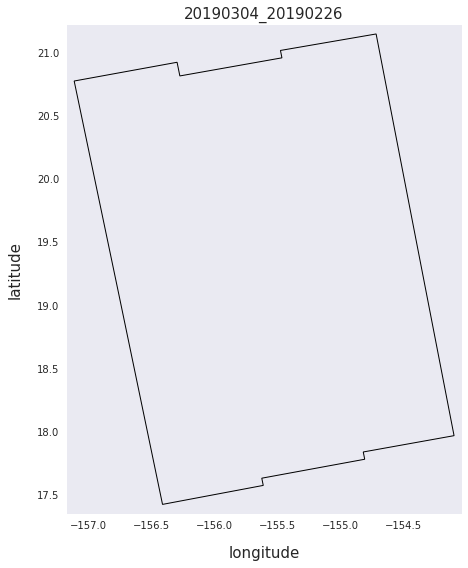

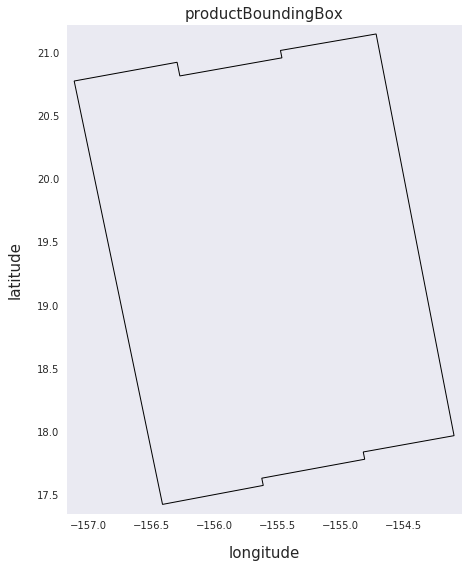

In [52]:
cmd    = "-f '{}' -d Download -w {}".format(' '.join(fileNames), res_dir)
# print ('Running extractProduct.py {}'.format(cmd))
!extractProduct.py {cmd}
# !extractProduct.py '-f {fileNames} -d Download -w {res_dir}'

## plot the results
shputil.plot_shapefile(os.path.join(res_dir, 'productBoundingBox', '20190304_20190226.shp'))
shputil.plot_shapefile(os.path.join(res_dir, 'productBoundingBox', 'productBoundingBox.shp'))

Since we are only using one interferogram and requested no spatial manipulations, the outline of the frames is identical to the final product bounding box.

### 3.1 Extract layer without a bounding box

Here we demonstrate how to extract a layer without using a bounding box with the frames over Hawai'i described in [Prep B](#Dowload-the-Data).

Layers are extracted to separate subdirectories of 'layer name' under the specified working directory (`-w`), e.g. 'results/amplitude'.
Within the layer subdirectories, the data and metadata are saved with the interferogram pair dates as the basename. Any existing layers will be overwritten.

We will here extract the amplitude, view it using our [plotting function](#plot_layer), and briefly discuss it.

extractProduct.py -f '/Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/extractProduct/data/S1-GUNW-A-R-124-tops-20190304_20190226-042953-19661N_17420N-PP-720e-v2_0_1.nc /Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/extractProduct/data/S1-GUNW-A-R-124-tops-20190304_20190226-043020-21158N_19086N-PP-5415-v2_0_1.nc' -l amplitude -d Download -w /Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/extractProduct/results
########################################
class 'Aria_standardproduct': sort input file(s) by starting time
if user bbox was specified, file(s) not meeting imposed spatial criteria are rejected.

Outputs = arrays ['standardproduct_info.products'] containing grouped “radarmetadata info” and “data layer keys+paths” dictionaries for each standard product + path to bbox file ['standardproduct_info.bbox_file'] (if bbox specified).

All 2 input files successfully passed!
Group spatiotemporally continuous IFGs.

All 1 input files successfully passed!


########

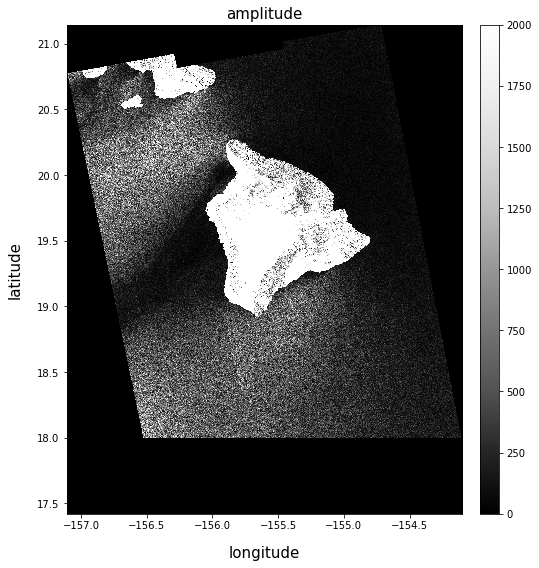

In [53]:
cmd    = "-f '{}' -l amplitude -d Download -w {}".format(' '.join(fileNames), res_dir,)

print ('extractProduct.py {}'.format(cmd))
!extractProduct.py {cmd}

# plot amplitude
plot_layer(os.path.join(res_dir, 'amplitude', '20190304_20190226'))

This amplitude plot shows the magnitude of the complex values at each pixel in the stitched interferometric pair. Weaker (darker) values indicate weaker backscatter of the radar signal, which depends on the charateristics of the surface. In the water region, amplitude is spatially heterogenous due to the spatial variability of waves and the local winds modulating them. However, if the sea were perfectly calm during both acquistions, the sea surface would effectively function as a mirror, causing specular reflection and thus very low, homogeneous amplitude.

### 3.2 Extract layer with SNWE coordinates
To focus analysis, the user can specify a rectangular bounding box of SNWE coordinates as a space delimited list surround by quotes.
Note that if the user ran the previous cell, he/she does not need to download a DEM; one could instead point to it with `-d ./res_docs/SRTM_3arcsec.dem`.

extractProduct.py -f '/Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/extractProduct/data/S1-GUNW-A-R-124-tops-20190304_20190226-042953-19661N_17420N-PP-720e-v2_0_1.nc /Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/extractProduct/data/S1-GUNW-A-R-124-tops-20190304_20190226-043020-21158N_19086N-PP-5415-v2_0_1.nc' -l coherence -d Download -w /Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/extractProduct/results --bbox '18.8 20.3 -156.1 -154.8'
########################################
class 'Aria_standardproduct': sort input file(s) by starting time
if user bbox was specified, file(s) not meeting imposed spatial criteria are rejected.

Outputs = arrays ['standardproduct_info.products'] containing grouped “radarmetadata info” and “data layer keys+paths” dictionaries for each standard product + path to bbox file ['standardproduct_info.bbox_file'] (if bbox specified).

Shapefile /Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/extractProduct/results/user_b

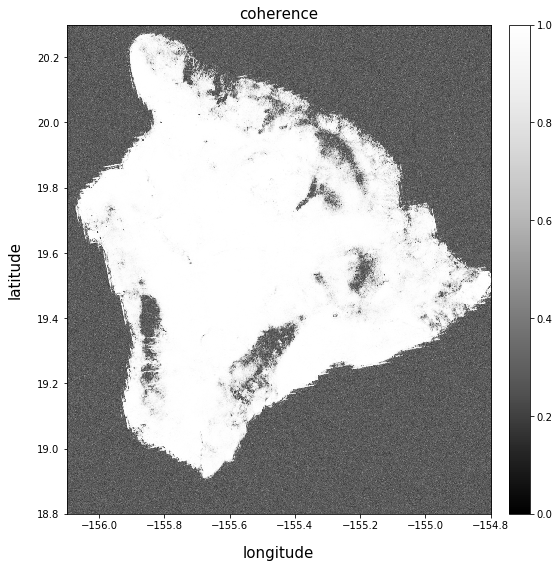

In [54]:
cmd    = "-f '{}' -l coherence -d Download -w {} --bbox '18.8 20.3 -156.1 -154.8'".format(' '.join(fileNames), res_dir)

print ('extractProduct.py {}'.format(cmd))
!extractProduct.py {cmd}

# plot coherence
plot_layer(os.path.join(res_dir, 'coherence', '20190304_20190226'))

The coherence plot shows the  similarity between observations in the two SAR images that compose the interferometric pair. 
Coherence ranges from 0 (no coherence) to 1 (identically coherent) and is degraded most notably by temporal decorrelation, or the change in wavelength-scale scatterer characteristics within a resolution cell between acquisitions.
Capillary waves superimposed on larger scale fluctuations cause water to have little coherence from one acquisition to the next, as seen above. Note that coherence is computed by averaging neighboring pixels using a 5 x 5 window, thus coarsening the pixel cell resolution from 90 m$^2$ to 450 m$^2$.

### 3.3  Extract layer using a shapefile
Another option for focusing on a region is to pass user defined data. *The data must be a vector dataset of polygon geometry, readable by GDAL*. 
The data should be referenced to **WGS84**.

Here we crop to a polygon containing the Big Island of Hawai'i. 
This shapefile was created from the [OpenStreetMap dataset](https://www.openstreetmap.org/) using the [OSMnx](https://geoffboeing.com/publications/osmnx-complex-street-networks/) python library.

We will extract and view the incidence angle.

extractProduct.py -f '/Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/extractProduct/data/S1-GUNW-A-R-124-tops-20190304_20190226-042953-19661N_17420N-PP-720e-v2_0_1.nc /Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/extractProduct/data/S1-GUNW-A-R-124-tops-20190304_20190226-043020-21158N_19086N-PP-5415-v2_0_1.nc' -l incidenceAngle -w /Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/extractProduct/support_docs -d Download -b /Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/extractProduct/support_docs/Big_Island/Big_Island.shp
########################################
class 'Aria_standardproduct': sort input file(s) by starting time
if user bbox was specified, file(s) not meeting imposed spatial criteria are rejected.

Outputs = arrays ['standardproduct_info.products'] containing grouped “radarmetadata info” and “data layer keys+paths” dictionaries for each standard product + path to bbox file ['standardproduct_info.bbox_file'] (if bbox specified).

All 2

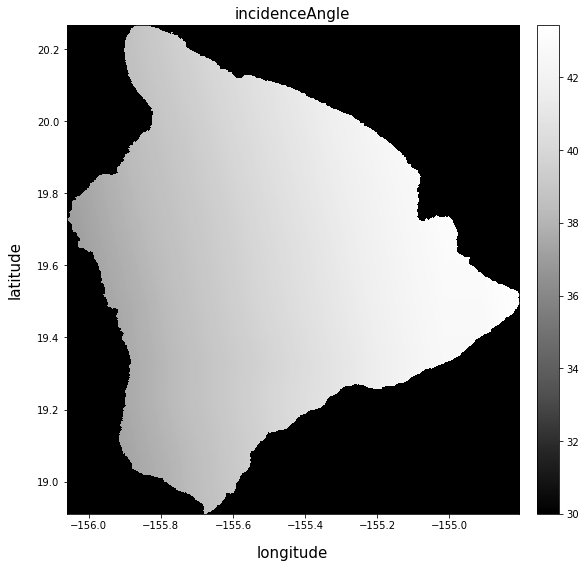

In [45]:
shp    = os.path.join(data_dir, 'Big_Island', 'Big_Island.shp')
cmd    = "-f '{}' -l incidenceAngle -w {} -d Download -b {}".format(' '.join(fileNames), data_dir, shp)
print ('extractProduct.py {}'.format(cmd))
!extractProduct.py {cmd}
plot_layer(os.path.join(res_dir, 'incidenceAngle', '20190304_20190226'))

The incidence angle is that formed between the vertical perpendicular to the ground and the incoming radar beam (Fig. 5). Here it generally decreases from east to west, from a high of $\sim43.5$ to a low of $\sim 37.0$.

<img src="support_docs/incidence_angle.png" alt="incidence_angle" width="250">

<blockquote><b>Fig. 4</b> Schematic showing incidence angle (source: <a href="https://earth.esa.int/handbooks/asar/CNTR5-5.html#eph.asar.gloss.geo:INCIDENCE">ESA Handbook</a>)  
 </blockquote>

### 3.4 Applying a Water Mask

For many applications we are only interested in proccesses occuring on land. 
Thus we provide the capability to apply a water mask to the stitched product.
Here we show how to download a vector of coastlines, rasterize it your bounding box, and plot it using GDAL.

--2019-05-10 08:25:15--  https://opendata.arcgis.com/datasets/045b1d5147634e2380566668e04094c6_3.zip
Resolving opendata.arcgis.com (opendata.arcgis.com)... 50.16.135.254, 52.206.105.171
Connecting to opendata.arcgis.com (opendata.arcgis.com)|50.16.135.254|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘/Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/extractProduct/data/Coastline.zip’

/Users/bb/Software_     [ <=>                ]   1.04M  --.-KB/s    in 0.1s    

2019-05-10 08:25:15 (8.07 MB/s) - ‘/Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/extractProduct/data/Coastline.zip’ saved [1091485]

extractProduct.py -f '/Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/extractProduct/data/S1-GUNW-A-R-124-tops-20190304_20190226-042953-19661N_17420N-PP-720e-v2_0_1.nc /Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/extractProduct/data/S1-GUNW-A-R-124-tops-20190304_20190226-043020-2

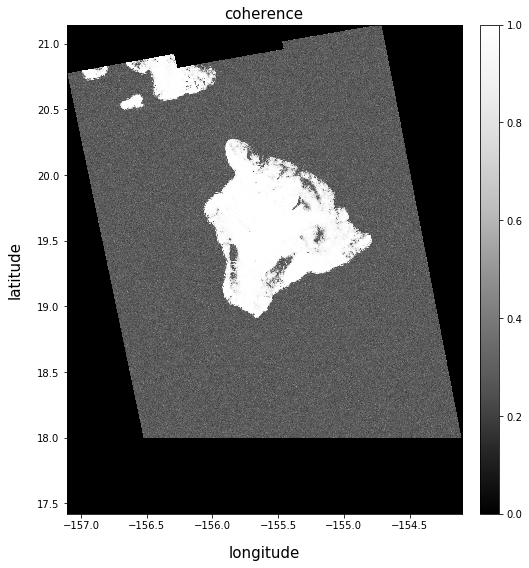

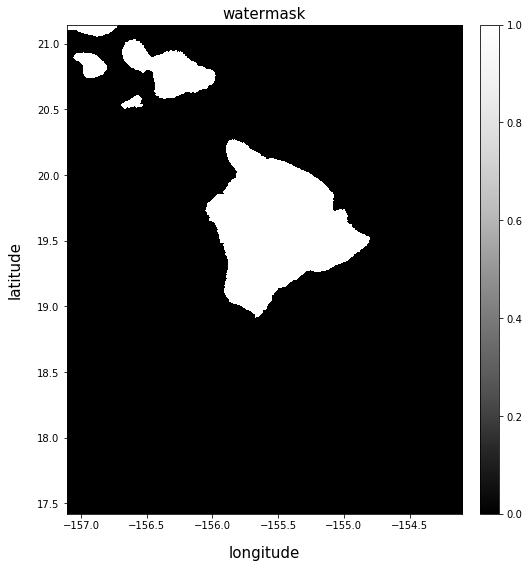

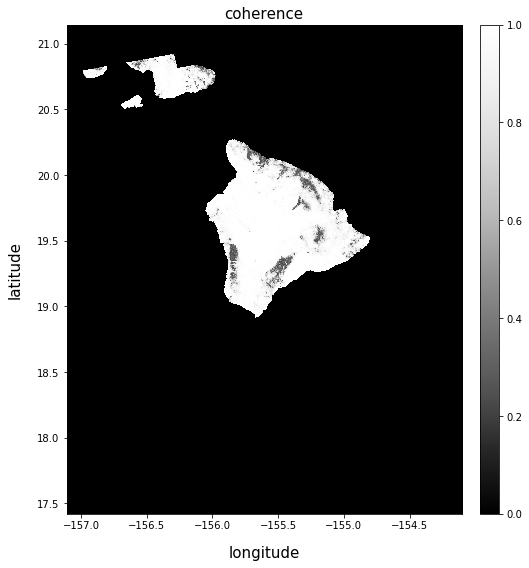

In [58]:
# first download the coastline data
!wget -O {data_dir}/Coastline.zip  https://opendata.arcgis.com/datasets/045b1d5147634e2380566668e04094c6_3.zip

## make the full image to use for the mask geometry
cmd    = "-f '{}' -l coherence -w {} -d Download".format(' '.join(fileNames), res_dir)
print ('extractProduct.py {}'.format(cmd))
!extractProduct.py {cmd}
plot_layer(os.path.join(res_dir, 'coherence', '20190304_20190226'))

## get the product to align to 
ds_prod = gdal.Open(os.path.join(res_dir, 'coherence', '20190304_20190226'), gdal.GA_ReadOnly)
                    
## get the coastlines
ds_lines = ogr.Open('/vsizip/{}/Coastline.zip'.format(data_dir), gdal.GA_ReadOnly)                 
layer    = ds_lines.GetLayerByIndex(0)
# create a copy of where the mask will be stored
ds_mask = gdal.GetDriverByName('MEM').CreateCopy('', ds_prod)                   

band = ds_mask.GetRasterBand(1)
## fill with 0 and rasterize
band.Fill(0)
gdal.RasterizeLayer(ds_mask,  # output to our new dataset
                    [1],  # output to our new dataset's first band
                    layer,  # rasterize this layer
                    None, None,  # don't worry about transformations since we're in same projection
                    [1])  # burn value 1

path_dst = os.path.join(res_dir, 'watermask')
ds_out   = gdal.Translate('{}.tif'.format(path_dst), ds_mask)
gdal.BuildVRT('{}.vrt'.format(path_dst), ds_out)                 

## get extents for plotting
plot_layer('{}.tif'.format(path_dst), 'watermask')

## finally lets apply the WaterMask and view the product
cmd    = "-f '{}' -l coherence -w {} -d Download -m ./results/watermask.tif".format(' '.join(fileNames), res_dir, path_dst)
print ('extractProduct.py {}'.format(cmd))
!extractProduct.py {cmd}

plot_layer(os.path.join(res_dir, 'coherence', '20190304_20190226'))

## Applications

### 4.1  ENU Conversion

For geophysical modeling and analysis, it is often useful to convert from the radar line-of-sight (LOS) to a Cartesian vector map (East, North, Up).

The conversion proceeds according to :
    \begin{equation}
    E = \sin(\theta)\cos(\alpha+\pi/2), \quad N = \sin(\theta)\sin(\alpha+\pi/2), \quad U = \cos(\theta)
    \end{equation}

where $\theta$ is the incidence angle and $\alpha$ is the azimuth angle in radians.

We extract the incidence and azimuth angles over the Big Island, and then perform the calculation using the python bindings for gdal.

In [59]:
## Create the necessary data
shp    = os.path.join(data_dir, 'Big_Island', 'Big_Island.shp')
cmd    = "-f '{}' -l 'incidenceAngle,azimuthAngle' -d Download -w {} --bbox {}".format(' '.join(fileNames), res_dir, shp)

print ('extractProduct.py {}'.format(cmd))
!extractProduct.py {cmd}

## setup the paths for the calculation
ifg      = '20190304_20190226'
path_src = [os.path.join(res_dir, layer, ifg) for layer in ['incidenceAngle', 'azimuthAngle']]
path_dst = os.path.join(res_dir, '{}_enu'.format(ifg))

ds       = gdal.Open(path_src[0], gdal.GA_ReadOnly)
arr_inc  = ds.ReadAsArray()
arr_azi  = gdal.Open(path_src[1], gdal.GA_ReadOnly).ReadAsArray()

## convert to radians and calculate
arr_incd = np.deg2rad(arr_inc)
arr_azid = np.deg2rad(arr_azi)
E = np.sin(arr_incd) * np.cos(arr_azid + np.pi/2)
N = np.sin(arr_incd) * np.sin(arr_azid + np.pi/2)
U = np.cos(arr_incd)

## copy the projection information into a memory; most formats dont support adding bands
ds_out = gdal.GetDriverByName('MEM').CreateCopy('', ds)

## write ENU to separate bands
for i, j in enumerate([E, N, U]):
    try:
        ds_out.GetRasterBand(i+1).WriteArray(j)
    except:
        # add a float 32 band when it doesn't exist
        ds_out.AddBand(gdal.GDT_Float32)
        ds_out.GetRasterBand(i+1).WriteArray(j)

## write dataset to disk and build a VRT for it
ds = gdal.Translate(path_dst, ds_out, format='ENVI')
gdal.BuildVRT('{}.vrt'.format(path_dst), ds)
del ds, ds_out

extractProduct.py -f '/Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/extractProduct/data/S1-GUNW-A-R-124-tops-20190304_20190226-042953-19661N_17420N-PP-720e-v2_0_1.nc /Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/extractProduct/data/S1-GUNW-A-R-124-tops-20190304_20190226-043020-21158N_19086N-PP-5415-v2_0_1.nc' -l 'incidenceAngle,azimuthAngle' -d Download -w /Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/extractProduct/results --bbox /Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/extractProduct/data/Big_Island/Big_Island.shp
########################################
class 'Aria_standardproduct': sort input file(s) by starting time
if user bbox was specified, file(s) not meeting imposed spatial criteria are rejected.

Outputs = arrays ['standardproduct_info.products'] containing grouped “radarmetadata info” and “data layer keys+paths” dictionaries for each standard product + path to bbox file ['standardproduct_info.bbox_file'] (if bbox specified).


<div class="alert alert-info">
    <b>DAVID:</b> there isn't a way using gdal_calc.py  to save to one file in separate bands; i checked and the method produces consistent results though.
    </div>

### 4.2 Deformation Map
We can convert the unwrapped phase in radians, ($\phi_u$) to deformation in *millimeters* ($D_p$) according to:
    $$ D_p = -1000\frac{4\pi}{\lambda}   \varphi_{uw} $$
   
where the $\lambda$ is the radar wavelength ($\sim5.6$ cm for Sentinel-1).
Multiplication by $-1000$ scales from meters to millimeters and reverses the direction, such that positive values in the resulting deformation map indicate uplift and negative values subsidence.

We now show how to extract the wavelength from the **GUNW** product, and compute and plot the deformation map.

########################################
class 'Aria_standardproduct': sort input file(s) by starting time
if user bbox was specified, file(s) not meeting imposed spatial criteria are rejected.

Outputs = arrays ['standardproduct_info.products'] containing grouped “radarmetadata info” and “data layer keys+paths” dictionaries for each standard product + path to bbox file ['standardproduct_info.bbox_file'] (if bbox specified).

All 2 input files successfully passed!
Group spatiotemporally continuous IFGs.

All 1 input files successfully passed!


########################################
fn 'merged_productbbox': extract/merge productBoundingBox layers for each pair and update dict, report common track bbox (default is to take common intersection, but user may specify union), and expected shape for DEM.



########################################
fn 'prep_dem': Pass DEM-filename, loaded DEM array, and lat/lon arrays.

[['NETCDF:"/Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/extr

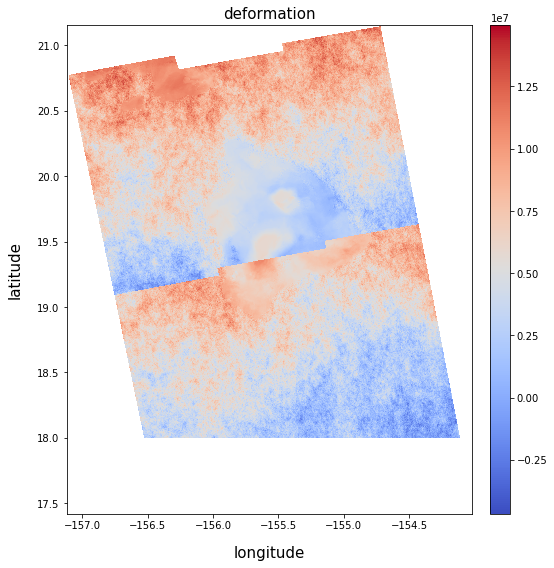

In [62]:
# extract the wavelength from one of the GUNW standard products
# wavelength = gdal.Open("NETCDF:"+fileNames[0]+":/science/radarMetaData/wavelength") # not currently supported
wavelength = 0.05546576 # m

## Create the necessary data
shp    = os.path.join(data_dir, 'Big_Island', 'Big_Island.shp')
cmd    = "-f '{}' -l unwrappedPhase -d Download -w {} --bbox {}".format(' '.join(fileNames), res_dir, shp)
!extractProduct.py {cmd}

ifg      = '20190304_20190226'
path_src = os.path.join(res_dir, 'unwrappedPhase', ifg)
path_dst = os.path.join(res_dir, '{}_defo'.format(ifg))

## use gdal_calc.py to perform the calculation
cmd    = "-A {}.vrt --outfile {} --calc='-1000*4*pi*A/{}' --format=ENVI --overwrite".format(path_src, path_dst, wavelength)
!gdal_calc.py {cmd}

## view the plot
plot_layer(path_dst, 'deformation')